In [2]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import curve_fit

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams.update({'font.size': 13, 'figure.figsize': (8, 6)})
import seaborn as sns
sns.set_style('white')

### Basic Parameter Estimation

In [3]:
plate1 = pd.read_csv('datasets/plate1.csv')
plate1 = plate1[:-1]
plate1['Time'] = pd.to_datetime(plate1['Time'])
col = 'D6'
plate1x = plate1.set_index('Time').resample('120min').mean()[col].reset_index().reset_index()
plate1x

,index,Time,D6
0,0,2021-03-05 00:00:00,0.064917
1,1,2021-03-05 02:00:00,0.060717
2,2,2021-03-05 04:00:00,0.059967
3,3,2021-03-05 06:00:00,0.059100
4,4,2021-03-05 08:00:00,0.059000
5,5,2021-03-05 10:00:00,0.059000
6,6,2021-03-05 12:00:00,0.059550
7,7,2021-03-05 14:00:00,0.070417
8,8,2021-03-05 16:00:00,0.181367
9,9,2021-03-05 18:00:00,0.499567


In [4]:
tspan = plate1x['index'][:-2]
Ca_data = plate1x[col][:-2]

def fitfunc(t, k1, k2, k3, k4):
    
    def cell_density_model(OD, t, max_growth_rate, max_carry_capacity, t1, t1lag):
        #dOD = max_growth_rate * (1 - (OD[0]/max_carry_capacity)) * OD[0]
        dOD = max_growth_rate * (1 - (OD[0]/max_carry_capacity)) / (1 + np.exp(-4 * (t1 - t1lag)))
        return dOD
    
    Ca0 = Ca_data[0]
    rates = (k1, k2, k3, k4)
    Casol = odeint(cell_density_model, Ca0, t, rates)
    return Casol[:,0]

k_fit, kcov = curve_fit(fitfunc, tspan, Ca_data)
print(k_fit)

[0.41230969 2.56955205 0.56742231 1.3486455 ]


/Users/mardian/Documents/Edinburgh/Notebook/env/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [5]:
tfit = np.linspace(0, 11);
fit = fitfunc(tfit, k_fit[0], k_fit[1])
print(fit)

plt.plot(tspan, Ca_data, 'ro', label='data')
plt.plot(tfit, fit, 'b-', label='fit')
plt.legend(loc='best')
plt.show()

TypeError: fitfunc() missing 2 required positional arguments: 'k3' and 'k4'

In [6]:
def cell_density_model(OD, t, max_growth_rate, max_carry_capacity):
    dOD = max_growth_rate * (1 - (OD[0]/max_carry_capacity)) * OD[0]
    return dOD

In [17]:
def hill_equation(x, top, bottom, K, n):
    return bottom + (top - bottom) * x**n / (K**n + x**n)

<ipython-input-17-b630865d8f71>:2: RuntimeWarning: divide by zero encountered in power
  return bottom + (top - bottom) * x**n / (K**n + x**n)
<ipython-input-17-b630865d8f71>:2: RuntimeWarning: invalid value encountered in true_divide
  return bottom + (top - bottom) * x**n / (K**n + x**n)


[ 0.92924342  0.0578681   9.03580603 14.00505349]


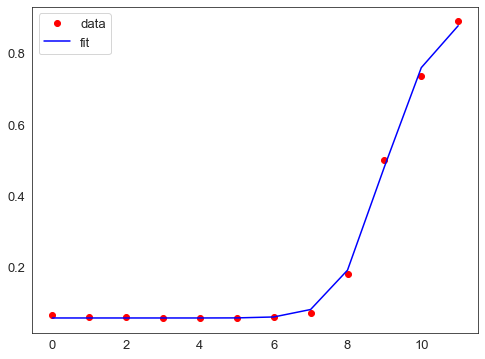

In [18]:
x, y = np.arange(len(plate1x)), plate1x[col]
popt, _ = curve_fit(hill_equation, x, y)
print(popt)

tfit = np.arange(len(plate1x))
fit = hill_equation(tfit, *popt)

plt.plot(x, y, 'ro', label='data')
plt.plot(tfit, fit, 'b-', label='fit')
plt.legend(loc='best')
plt.show()

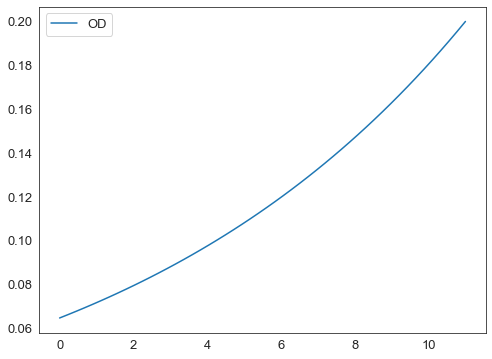

In [7]:
t = np.linspace(0, 11)
rates = (1.02498147e-01, 5.16560009e+03)
OD = [0.06468333333333334]
y = odeint(cell_density_model, OD, t, rates)

plt.plot(t, y[:,0], label='OD')
plt.legend()
plt.show()

### DNA Nanotechnology Project

In [31]:
def perfect_model(y, t, k1, k2, k3, k1a, k2a, k3a, k1d, k2d, k3d):
    A = k3 * y[0] * y[2] - k1 * y[0] * y[1] - k1d * y[0] + k1a * y[3] * y[0]
    B = k1 * y[1] * y[0] - k2 * y[1] * y[2] - k2d * y[1] + k2a * y[4] * y[1]
    C = k2 * y[2] * y[1] - k3 * y[2] * y[0] - k3d * y[2] + k3a * y[5] * y[2]
    D = -1 * k1a * y[3] * y[0]
    E = -1 * k2a * y[4] * y[1]
    F = -1 * k3a * y[5] * y[2]
    return [A, B, C, D, E, F]

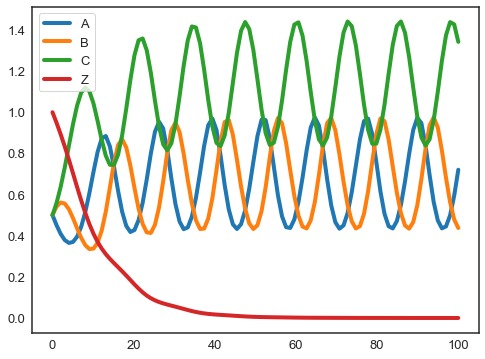

In [32]:
t = np.linspace(0, 100, 100)
rates = (0.5, 0.3, 0.3, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0)
y0 = [0.5, 0.5, 0.5, 0, 0, 1.0]
y = odeint(perfect_model, y0, t, rates)

plt.plot(t, y.transpose()[0], label='A')
plt.plot(t, y.transpose()[1], label='B')
plt.plot(t, y.transpose()[2], label='C')
plt.plot(t, y.transpose()[5], label='Z')
plt.legend()
plt.show()

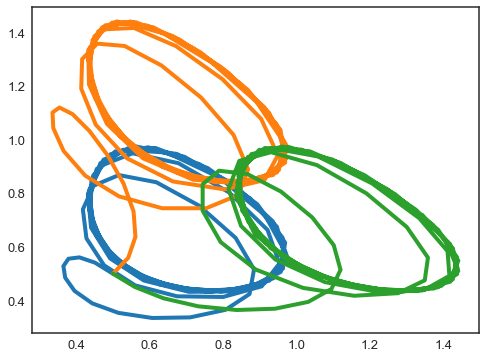

In [33]:
plt.plot(y.transpose()[0], y.transpose()[1])
plt.plot(y.transpose()[1], y.transpose()[2])
plt.plot(y.transpose()[2], y.transpose()[0])
plt.show()

In [34]:
def lotka_voltera(y, t, r1, r2, k12, k21, K1, K2):
    A = r1 * y[0] * (1 - ((y[0] + k12 * y[1]) / K1))
    B = r2 * y[1] * (1 - ((y[1] + k21 * y[0]) / K2))
    return [A, B]

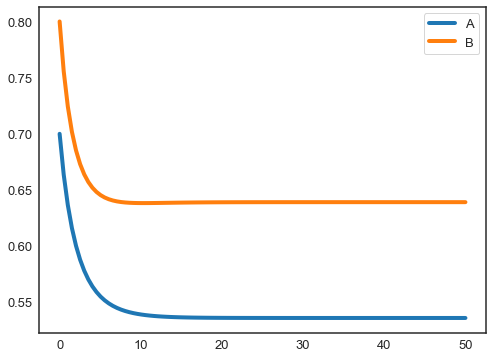

In [35]:
t = np.linspace(0, 50, 100)
rates = (0.4, 0.5, 0.1, 0.3, 0.6, 0.8)
y0 = [0.7, 0.8]
y = odeint(lotka_voltera, y0, t, rates)

plt.plot(t, y.transpose()[0], label='A')
plt.plot(t, y.transpose()[1], label='B')
plt.legend()
plt.show()

In [43]:
def ideal_two_to_two(y, t, k1, k2):
    
    A = -1 * k1 * y[0] * y[1]
    B = -1 * k1 * y[0] * y[1]
    C = k1 * y[0] * y[1]
    D = k1 * y[0] * y[1]
    
    return [A, B, C, D]

### Join Operator

In [44]:
def join2x2(y, t, k1, k2, k3, k4, k5):
    '''
    k1 is forward reaction for A+T1->T2+I1
    k2 is backward reaction for A+T1->T2+I1
    k3 is forward reaction for B+T2->T3+I2
    k4 is backward reaction for B+T2->T3+I2
    k5 is forward reaction for L+T3->C+D+W
    '''
    
    A = -1 * k1 * y[0] * y[1] + k2 * y[2] * y[3]
    T1 = -1 * k1 * y[0] * y[1] + k2 * y[2] * y[3]
    T2 = k1 * y[0] * y[1] - k2 * y[2] * y[3] - k3 * y[4] * y[2] + k4 * y[5] * y[6]
    I1 = k1 * y[0] * y[1] - k2 * y[2] * y[3]
    
    B = -1 * k3 * y[4] * y[2] + k4 * y[5] * y[6]
    T3 = k3 * y[4] * y[2] - k4 * y[5] * y[6] - k5 * y[7] * y[5]
    I2 = k3 * y[4] * y[2] - k4 * y[5] * y[6]
    
    L = -1 * k5 * y[7] * y[5]
    W = k5 * y[7] * y[5]
    C = k5 * y[7] * y[5]
    D = k5 * y[7] * y[5]
    
    return [A, T1, T2, I1, B, T3, I2, L, W, C, D]

def join2x2_osc(y, t, k1, k2, k3, k4, k5):
    '''
    k1 is forward reaction for A+T1->T2+I1
    k2 is backward reaction for A+T1->T2+I1
    k3 is forward reaction for B+T2->T3+I2
    k4 is backward reaction for B+T2->T3+I2
    k5 is forward reaction for L+T3->C+D+W
    '''
    
    A = -1 * k1 * y[0] * y[1] + k2 * y[2] * y[3]
    T1 = -1 * k1 * y[0] * y[1] + k2 * y[2] * y[3]
    T2 = k1 * y[0] * y[1] - k2 * y[2] * y[3] - k3 * y[4] * y[2] + k4 * y[5] * y[6]
    I1 = k1 * y[0] * y[1] - k2 * y[2] * y[3]
    
    B = -1 * k3 * y[4] * y[2] + k4 * y[5] * y[6] + k5 * y[7] * y[5] + k5 * y[7] * y[5]
    T3 = k3 * y[4] * y[2] - k4 * y[5] * y[6] - k5 * y[7] * y[5]
    I2 = k3 * y[4] * y[2] - k4 * y[5] * y[6]
    
    L = -1 * k5 * y[7] * y[5]
    W = k5 * y[7] * y[5]
    #C = k5 * y[7] * y[5]
    #D = k5 * y[7] * y[5]
    
    A = -1 * k6 * y[0] * y[1] + k7 * y[2] * y[3]
    T1 = -1 * k6 * y[0] * y[1] + k7 * y[2] * y[3]
    T2 = k6 * y[0] * y[1] - k7 * y[2] * y[3] - k8 * y[4] * y[2] + k9 * y[5] * y[6]
    I1 = k6 * y[0] * y[1] - k7 * y[2] * y[3]
    
    B = -1 * k8 * y[4] * y[2] + k9 * y[5] * y[6] + k10 * y[7] * y[5] + k10 * y[7] * y[5]
    T3 = k8 * y[4] * y[2] - k9 * y[5] * y[6] - k10 * y[7] * y[5]
    I2 = k8 * y[4] * y[2] - k9 * y[5] * y[6]
    
    L = -1 * k10 * y[7] * y[5]
    W = k10 * y[7] * y[5]
    
    return [A, T1, T2, I1, B, T3, I2, L, W]

def reporter(y, t, k, k2):
    
    X = -1 * k * y[0] * y[1]
    T = -1 * k * y[0] * y[1]
    Y = k * y[0] * y[1]
    W = k * y[0] * y[1]
    
    return [X, T, Y, W]

In [45]:
def mapNxN(inputs, gate, outputs, rates, length, fuel_ratio=1, show_intermediate=False):
    
    y0 = [inputs[0][1], gate[1], 0, 0, inputs[1][1], 0, 0, fuel_ratio * gate[1], 0]
    t = np.linspace(0, length)
    y = odeint(join2x2, y0, t, rates)
    
    y_mapped = y.transpose()
    
    out = []
    if not show_intermediate:
        
        out = [(inputs[0][0], y_mapped[0]),
             (inputs[1][0], y_mapped[4]),
             (outputs[0][0], y_mapped[9]),
             (outputs[1][0], y_mapped[10]),
             (gate[0], y_mapped[1])]
        
    return t, out

def map_oscillator(inputs, gate, outputs, rates, length, fuel_ratio=1, show_intermediate=False):
    
    y0 = [inputs[0][1], gate[1], 0, 0, inputs[1][1], 0, 0, fuel_ratio * gate[1], 0]
    t = np.linspace(0, length)
    y = odeint(join2x2_osc, y0, t, rates)
    
    y_mapped = y.transpose()
    
    out = []
    if not show_intermediate:
        
        out = [(inputs[0][0], y_mapped[0]),
             (inputs[1][0], y_mapped[4]),
             (gate[0], y_mapped[1])]
        
    return t, out

def map1x0(inputs, gate, outputs, rates, length):
    
    y0 = [inputs[0][1], gate[1], 0, 0]
    t = np.linspace(0, length)
    y = odeint(reporter, y0, t, rates)
    
    y_mapped = y.transpose()
    return t, [(inputs[0][0], y_mapped[0]),
           (gate[0], y_mapped[1])]
    

In [46]:
inputs = [('A', 10), ('B', 10)]
outputs = [('B', 0), ('B', 0)]
gate = ('Gate_AB', 10)
t, out = mapNxN_osc(inputs, gate, outputs, (0.2, 0.2, 0.2, 0.2, 0.2), 20, fuel_ratio=5)

for o in out:
    plt.plot(t, o[1], label=o[0])
plt.title('DNA-Based Model')
plt.legend()
plt.show()

NameError: name 'mapNxN_osc' is not defined

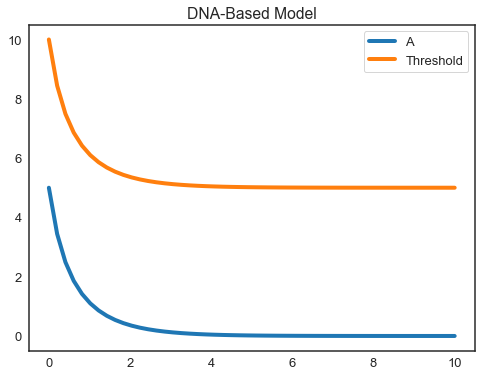

In [47]:
inputs = [('A', 5)]
outputs = []
gate = ('Threshold', 10)
t, out = map1x0(inputs, gate, outputs, (0.2, 0.1), 10)

for o in out:
     plt.plot(t, o[1], label=o[0])
plt.title('DNA-Based Model')
plt.legend()
plt.show()

In [48]:
t = np.linspace(0, 20, 100)
rates = (0.8, 0.8, 0.8, 0.8, 2)
input1 = 10
input2 = 10
gate2x2 = 10
fuel2x2 = 10
y0 = [input1, gate2x2, 0, 0, input2, 0, 0, fuel2x2, 0, 0, 0]
y = odeint(two_to_two, y0, t, rates)

t1 = np.linspace(0, 20, 100)
rates1 = (0.8, 0.8)
y01 = [10, 10, 0, 0]
y1 = odeint(ideal_two_to_two, y01, t1, rates1)

plt.subplot(121)
y_mapped = y.transpose()
plt.plot(t, y_mapped[0], label='A')
plt.plot(t, y_mapped[4], label='B')
plt.plot(t, y_mapped[9], label='C')
plt.plot(t, y_mapped[10], label='D')
plt.title('DNA-Based Model')
plt.legend()

plt.subplot(122)
y1_mapped = y1.transpose()
plt.plot(t1, y1_mapped[0], label='A')
plt.plot(t1, y1_mapped[1], label='B')
plt.plot(t1, y1_mapped[2], label='C')
plt.plot(t1, y1_mapped[3], label='D')
plt.title('Ideal Model')
plt.legend()

plt.show()

NameError: name 'two_to_two' is not defined

In [49]:
def reporter(y, t, k, k2):
    
    X = -1 * k * y[0] * y[1]
    T = -1 * k * y[0] * y[1]
    Y = k * y[0] * y[1]
    W = k * y[0] * y[1]
    
    return [X, T, Y, W]

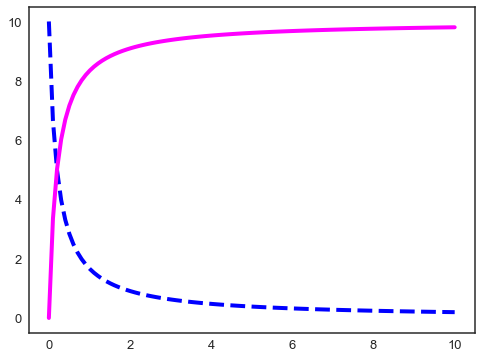

In [50]:
t = np.linspace(0, 10, 100)
rates = (0.5, 0)
y0 = [10, 10, 0, 0]
y = odeint(reporter, y0, t, rates)

y_mapped = y.transpose()
plt.plot(t, y_mapped[0], label='Signal', color='blue', linestyle='--')
plt.plot(t, y_mapped[3], label='ROX', color='magenta')

### Oscillator

In [ ]:
def osc_operator(y, t, k1ab, k1bc, k1ca, k2ab, k2bc, k2ca, k3ab, k3bc, k3ca, k4ab, k4bc, k4ca, k5ab, k5bc, k5ca):
    '''
    k1 is forward reaction for A+T1->T2+I1
    k2 is backward reaction for A+T1->T2+I1
    k3 is forward reaction for B+T2->T3+I2
    k4 is backward reaction for B+T2->T3+I2
    k5 is forward reaction for L+T3->C+D+W
    '''
    A, B, C, T1ab, T1bc, T1ca, Fab, Fbc, Fca, T2ab, T2bc, T2ca, T3ab, T3bc, T3ca, I1ab, I1bc, I1ca, I2ab, I2bc, I2ca, Wab, Wbc, Wca = y
    #k1ab, k1bc, k1ca, k2ab, k2bc, k2ca, k3ab, k3bc, k3ca, k4ab, k4bc, k4ca, k5ab, k5bc, k5ca = k
    
    A1 = -1 * k1ab * A * T1ab + k2ab * T2ab * I1ab - k3ca * A * T2ca + k4ca * T3ca * I2ca + k5ca * Fca * T3ca + k5ca * Fca * T3ca
    B1 = -1 * k1bc * B * T1bc + k2bc * T2bc * I1bc - k3ab * B * T2ab + k4ab * T3ab * I2ab + k5ab * Fab * T3ab + k5ab * Fab * T3ab 
    C1 = -1 * k1ca * C * T1ca + k2ca * T2ca * I1ca - k3bc * C * T2bc + k4bc * T3bc * I2bc + k5bc * Fbc * T3bc + k5bc * Fbc * T3bc
    
    T1ab1 = -1 * k1ab * A * T1ab + k2ab * T2ab * I1ab
    T1bc1 = -1 * k1bc * B * T1bc + k2bc * T2bc * I1bc
    T1ca1 = -1 * k1ca * C * T1ca + k2ca * T2ca * I1ca
    
    T2ab1 = k1ab * A * T1ab - k2ab * T2ab * I1ab - k3ab * B * T2ab + k4ab * T3ab * I2ab
    T2bc1 = k1bc * B * T1bc - k2bc * T2bc * I1bc - k3bc * C * T2bc + k4bc * T3bc * I2bc
    T2ca1 = k1ca * C * T1ca - k2ca * T2ca * I1ca - k3ca * A * T2ca + k4ca * T3ca * I2ca
    
    I1ab1 = k1ab * A * T1ab - k2ab * T2ab * I1ab
    I1bc1 = k1bc * B * T1bc - k2bc * T2bc * I1bc
    I1ca1 = k1ca * C * T1ca - k2ca * T2ca * I1ca
    
    T3ab1 = k3ab * B * T2ab - k4ab * T3ab * I2ab - k5ab * Fab * T3ab
    T3bc1 = k3bc * C * T2bc - k4bc * T3bc * I2bc - k5bc * Fbc * T3bc
    T3ca1 = k3ca * A * T2ca - k4ca * T3ca * I2ca - k5ca * Fca * T3ca
    
    I2ab1 = k3ab * B * T2ab - k4ab * T3ab * I2ab
    I2bc1 = k3bc * C * T2bc - k4bc * T3bc * I2bc
    I2ca1 = k3ca * A * T2ca - k4ca * T3ca * I2ca
    
    Fab1 = -1 * k5ab * Fab * T3ab
    Fbc1 = -1 * k5bc * Fbc * T3bc
    Fca1 = -1 * k5ca * Fca * T3ca
    
    Wab1 = k5ab * Fab * T3ab
    Wbc1 = k5bc * Fbc * T3bc
    Wca1 = k5ca * Fca * T3ca
    
    return [A, B, C, T1ab1, T1bc1, T1ca1, Fab1, Fbc1, Fca1, T2ab1, T2bc1, T2ca1, T3ab1, T3bc1, T3ca1,
            I1ab1, I1bc1, I1ca1, I2ab1, I2bc1, I2ca1, Wab1, Wbc1, Wca1]

In [ ]:
def oscillator(signals, gates, fuels, rates, length):
    
    signals_in = [i[1] for i in signals]
    gates_in = [i[1] for i in gates]
    fuels_in = [i[1] for i in fuels]
    remains_in = [0.0] * 15
    
    y0 = signals_in + gates_in + fuels_in + remains_in
    #y0 = [inputs[0][1], gate[1], 0, 0, inputs[1][1], 0, 0, fuel_ratio * gate[1], 0]
    t = np.linspace(0, length)
    y = odeint(osc_operator, y0, t, rates)
    y_mapped = y.transpose()
    
    out = [(signals[0][0], y_mapped[0]),
             (signals[1][0], y_mapped[1]),
             (signals[2][0], y_mapped[2])]
        
    return t, out

In [ ]:
signals = [('A', 10), ('B', 0), ('C', 0)]
gates = [('Gate_AB', 10), ('Gate_BC', 10), ('Gate_CA', 10)]
fuels = [('Fab', 10), ('Fbc', 10), ('Fca', 8)]
rates = (0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2)

t, out = oscillator(signals, gates, fuels, rates, 20)

for o in out:
    plt.plot(t, o[1], label=o[0])
plt.title('DNA-Based Model')
plt.legend()
plt.show()

In [ ]:
def join(y, t, k1ab, k2ab, k3ab, k4ab, k5ab):
    '''
    k1 is forward reaction for A+T1->T2+I1
    k2 is backward reaction for A+T1->T2+I1
    k3 is forward reaction for B+T2->T3+I2
    k4 is backward reaction for B+T2->T3+I2
    k5 is forward reaction for L+T3->C+D+W
    '''
    
    A = -1 * k1ab * y[0] * y[4] + k2ab * y[6] * y[8]
    B = -1 * k3ab * y[1] * y[6] + k4ab * y[7] * y[9] + k5ab * y[5] * y[7] + k5ab * y[5] * y[7]
    
    T1ab = -1 * k1ab * y[0] * y[4] + k2ab * y[6] * y[8]
    
    T2ab = k1ab * y[0] * y[4] - k2ab * y[6] * y[8] - k3ab * y[1] * y[6] + k4ab * y[7] * y[9]
    
    T3ab = k3ab * y[1] * y[6] - k4ab * y[7] * y[9] - k5ab * y[5] * y[7]
    
    I1ab = k1ab * y[0] * y[4] - k2ab * y[6] * y[8]
    
    I2ab = k3ab * y[1] * y[6] - k4ab * y[7] * y[9]
    
    Fab = -1 * k5ab * y[5] * y[7]
    Wab = k5ab * y[5] * y[7]
    
    
    C = 0
    D = 0
    #C = k5ab * y[5] * y[7]
    #D = k5ab * y[5] * y[7]
    
    return [A, B, C, D, T1ab, Fab, T2ab, T3ab, I1ab, I2ab, Wab]

def mapNxN(inputs, gate, outputs, rates, length, fuel_ratio=1, show_intermediate=False):
    
    y0 = [inputs[0][1], inputs[1][1], 0, 0, gate[1], fuel_ratio * gate[1], 0, 0, 0, 0, 0]
    t = np.linspace(0, length)
    y = odeint(join, y0, t, rates)
    
    y_mapped = y.transpose()
    
    out = [(inputs[0][0], y_mapped[0]),
             (inputs[1][0], y_mapped[1]),
             (outputs[0][0], y_mapped[2]),
             (outputs[1][0], y_mapped[3]),
             (gate[0], y_mapped[4])]
        
    return t, out

inputs = [('A', 10), ('B', 10)]
outputs = [('C', 0), ('D', 10)]
gate = ('Gate_AB', 10)
t, out = mapNxN(inputs, gate, outputs, (0.2, 0.2, 0.2, 0.2, 0.2), 20, fuel_ratio=5)

for o in out:
    plt.plot(t, o[1], label=o[0])
plt.title('DNA-Based Model')
plt.legend()
plt.show()